In [1]:
import os
import PIL
import tensorflow as tf
import pathlib
import cv2
import numpy as np
import keras
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

2023-10-27 20:51:29.481082: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-27 20:51:31.240264: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-27 20:51:31.240390: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-27 20:51:31.249092: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-27 20:51:32.082969: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-27 20:51:32.087461: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
data_dir = pathlib.Path("Datasets")
data_dir

PosixPath('Datasets')

In [3]:
image_count = len(list(data_dir.glob("*/*.[jJ][pP][gG]")))
image_count

284

In [4]:
skin_cancer_images_dict = {
    'cancer': list(data_dir.glob('Cancer/*')),
    'non_cancer': list(data_dir.glob('Non_Cancer/*'))
}

skin_cancer_label_dict = {
    'cancer': 0,
    'non_cancer': 1
}

In [5]:
X, y = [], []

for input_image, images in skin_cancer_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        if img is not None:  # Check if the image was loaded successfully
            img = cv2.resize(img, (180, 180))
            X.append(img)
            y.append(skin_cancer_label_dict[input_image])
        else:
            # Handle the case where the image could not be loaded or is empty
            print(f"Skipping image: {image}")


Skipping image: Datasets/Cancer/.ipynb_checkpoints


In [6]:
X = np.array(X)
y = np.array(y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [8]:
X_train_scaled = X_train/255
X_test_scaled = X_test/255

In [9]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(180, 180, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.3),
  ]
)

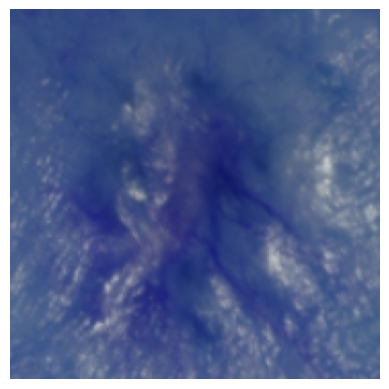

In [10]:
plt.axis("off")
plt.imshow(data_augmentation(X)[0].numpy().astype("uint8"))

In [11]:
num_classes = 2

model = Sequential([
    data_augmentation,
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes)
])

model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

In [27]:
model.fit(X_train_scaled, y_train, epochs = 20)

Epoch 1/20
7/7 [==============================] - 1s 209ms/step - loss: 0.0560 - accuracy: 0.9671
Epoch 2/20
7/7 [==============================] - 2s 214ms/step - loss: 0.0607 - accuracy: 0.9765
Epoch 3/20
7/7 [==============================] - 1s 206ms/step - loss: 0.0317 - accuracy: 0.9906
Epoch 4/20
7/7 [==============================] - 2s 219ms/step - loss: 0.0353 - accuracy: 0.9906
Epoch 5/20
7/7 [==============================] - 2s 213ms/step - loss: 0.0416 - accuracy: 0.9859
Epoch 6/20
7/7 [==============================] - 2s 218ms/step - loss: 0.0325 - accuracy: 0.9859
Epoch 7/20
7/7 [==============================] - 1s 203ms/step - loss: 0.0210 - accuracy: 0.9953
Epoch 8/20
7/7 [==============================] - 1s 207ms/step - loss: 0.0234 - accuracy: 0.9953
Epoch 9/20
7/7 [==============================] - 1s 206ms/step - loss: 0.0185 - accuracy: 1.0000
Epoch 10/20
7/7 [==============================] - 1s 206ms/step - loss: 0.0430 - accuracy: 0.9812
Epoch 11/20
7/7 [==

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)       

In [29]:
model.save("Maths_Cancer.h5")

/home/u204854/.local/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
from sklearn.metrics import precision_score, f1_score, confusion_matrix

# Make predictions on the test data
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate precision and F1 score
precision = precision_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

print("Precision:", precision)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

3/3 [==============================] - 0s 26ms/step
Precision: 0.8545454545454545
F1 Score: 0.8785046728971962
Confusion Matrix:
[[11  8]
 [ 5 47]]


Epoch 1/20
7/7 [==============================] - 2s 214ms/step - loss: 0.0313 - accuracy: 0.9906
Epoch 2/20
7/7 [==============================] - 1s 207ms/step - loss: 0.0189 - accuracy: 1.0000
Epoch 3/20
7/7 [==============================] - 1s 206ms/step - loss: 0.0458 - accuracy: 0.9812
Epoch 4/20
7/7 [==============================] - 2s 215ms/step - loss: 0.0685 - accuracy: 0.9859
Epoch 5/20
7/7 [==============================] - 1s 213ms/step - loss: 0.0207 - accuracy: 0.9906
Epoch 6/20
7/7 [==============================] - 2s 215ms/step - loss: 0.0144 - accuracy: 0.9953
Epoch 7/20
7/7 [==============================] - 1s 208ms/step - loss: 0.0279 - accuracy: 0.9859
Epoch 8/20
7/7 [==============================] - 2s 214ms/step - loss: 0.0251 - accuracy: 0.9906
Epoch 9/20
7/7 [==============================] - 2s 215ms/step - loss: 0.0206 - accuracy: 0.9953
Epoch 10/20
7/7 [==============================] - 2s 215ms/step - loss: 0.0229 - accuracy: 1.0000
Epoch 11/20
7/7 [==

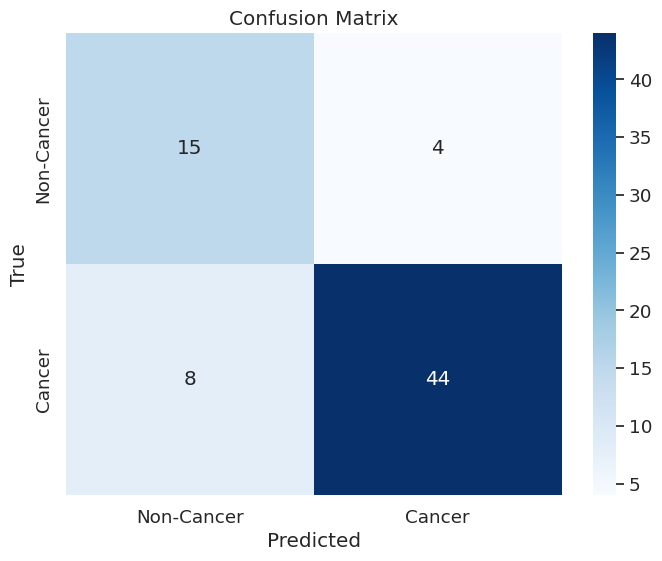

Accuracy: 0.8309859154929577


In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Train your model for 20 epochs
model.fit(X_train_scaled, y_train, epochs=20)

# Assuming you have already trained your model and obtained predictions
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Non-Cancer', 'Cancer'], yticklabels=['Non-Cancer', 'Cancer'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy based on the confusion matrix
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix)
print("Accuracy:", accuracy)

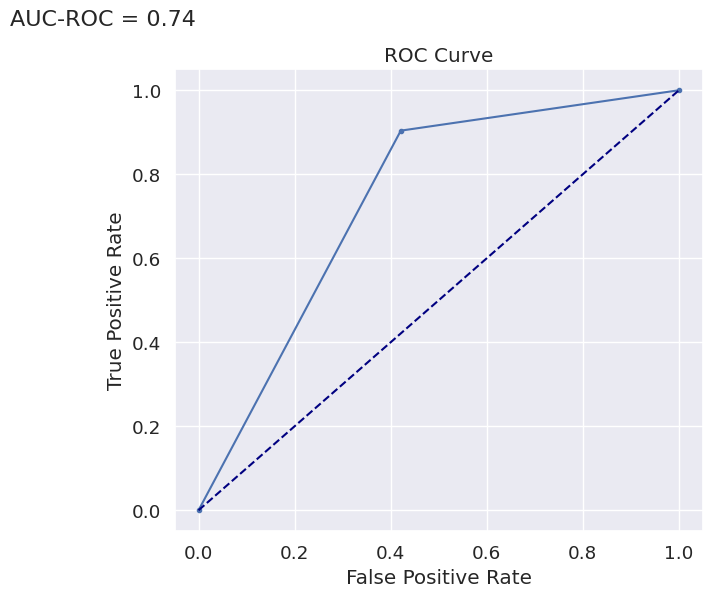

In [32]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# Calculate precision-recall values
precision, recall, _ = precision_recall_curve(y_test, y_pred_classes)

# Calculate ROC values
fpr, tpr, _ = roc_curve(y_test, y_pred_classes)

# Calculate AUC for ROC curve
roc_auc = auc(fpr, tpr)

# Create the subplots
plt.figure(figsize=(15, 6))

# Plot the ROC Curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

# Display AUC-ROC value
plt.suptitle(f'AUC-ROC = {roc_auc:.2f}', fontsize=16)

plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Replace these with your actual image data and labels
sample_images = X_train  # Your image data
sample_labels = y_train  # Labels corresponding to the images

# Define the number of rows and columns for the grid
num_rows = 4
num_cols = 4

# Create a figure and a set of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        if index < len(sample_images):
            ax = axes[i, j]
            ax.imshow(sample_images[index])
            ax.set_title(f'Label: {sample_labels[index]}')
            ax.axis('off')

# Adjust spacing and layout
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Epoch 1/20
6/6 [==============================] - 1s 219ms/step - loss: 0.0717 - accuracy: 0.9647 - val_loss: 0.6952 - val_accuracy: 0.8605
Epoch 2/20
6/6 [==============================] - 1s 215ms/step - loss: 0.0606 - accuracy: 0.9824 - val_loss: 0.5533 - val_accuracy: 0.8605
Epoch 3/20
6/6 [==============================] - 1s 208ms/step - loss: 0.0544 - accuracy: 0.9824 - val_loss: 0.4962 - val_accuracy: 0.8837
Epoch 4/20
6/6 [==============================] - 1s 208ms/step - loss: 0.0568 - accuracy: 0.9765 - val_loss: 0.4928 - val_accuracy: 0.9302
Epoch 5/20
6/6 [==============================] - 1s 212ms/step - loss: 0.0285 - accuracy: 1.0000 - val_loss: 0.6005 - val_accuracy: 0.8605
Epoch 6/20
6/6 [==============================] - 1s 208ms/step - loss: 0.0293 - accuracy: 0.9882 - val_loss: 0.6108 - val_accuracy: 0.8837
Epoch 7/20
6/6 [==============================] - 1s 200ms/step - loss: 0.0349 - accuracy: 0.9941 - val_loss: 0.7840 - val_accuracy: 0.9070
Epoch 8/20
6/6 [====

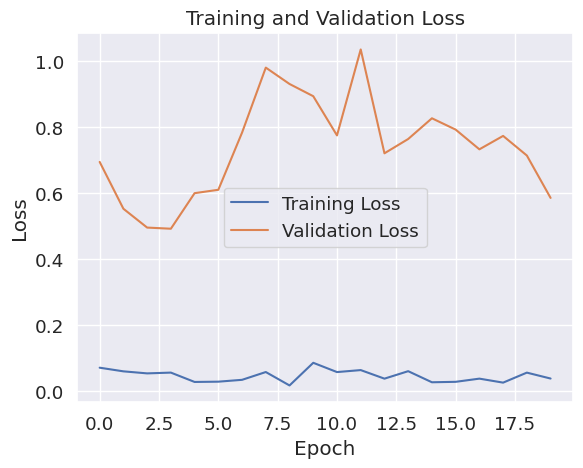

In [25]:
import matplotlib.pyplot as plt

# Assuming you have already defined and compiled your model as shown in your code

# Train your model, and keep track of the training history
history = model.fit(X_train_scaled, y_train, epochs=20, validation_split=0.2)

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1/20
6/6 [==============================] - 1s 224ms/step - loss: 0.0191 - accuracy: 0.9882 - val_loss: 0.3104 - val_accuracy: 0.9535
Epoch 2/20
6/6 [==============================] - 1s 207ms/step - loss: 0.0481 - accuracy: 0.9824 - val_loss: 0.3968 - val_accuracy: 0.9302
Epoch 3/20
6/6 [==============================] - 1s 209ms/step - loss: 0.0285 - accuracy: 0.9941 - val_loss: 0.1622 - val_accuracy: 0.9767
Epoch 4/20
6/6 [==============================] - 1s 212ms/step - loss: 0.0290 - accuracy: 0.9941 - val_loss: 0.0596 - val_accuracy: 0.9767
Epoch 5/20
6/6 [==============================] - 1s 208ms/step - loss: 0.0590 - accuracy: 0.9765 - val_loss: 0.0754 - val_accuracy: 0.9767
Epoch 6/20
6/6 [==============================] - 1s 215ms/step - loss: 0.0951 - accuracy: 0.9706 - val_loss: 0.1908 - val_accuracy: 0.9302
Epoch 7/20
6/6 [==============================] - 1s 203ms/step - loss: 0.0656 - accuracy: 0.9706 - val_loss: 0.0747 - val_accuracy: 0.9767
Epoch 8/20
6/6 [====

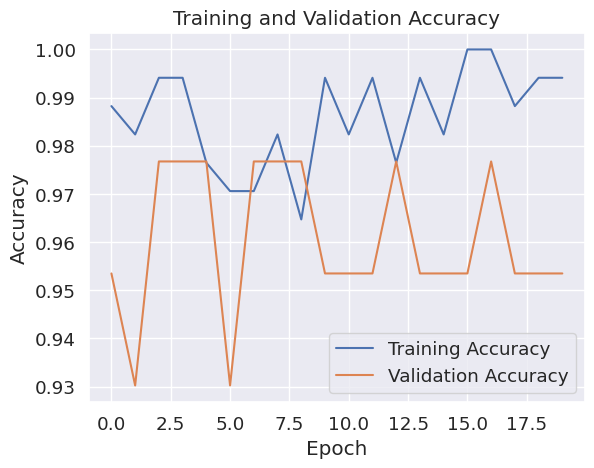

In [40]:
import matplotlib.pyplot as plt

history = model.fit(X_train_scaled, y_train, epochs=20, validation_split=0.2)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
